In [1]:
pathsTreino = {
    "camera1": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera1.txt"],
    "camera3": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera3.txt"],
    "camera5": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera5.txt"],
    "camera7": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera7.txt"],
    "camera9": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera9.txt"],
    "UFPR04": ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/UFPR04.txt"],
    "UFPR05": ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/UFPR05.txt"],
    "A": ["CNRPark-Patches-150x150/", "splits/CNRParkAB/A.txt"]
}
pathsTeste = {
    "camera2": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera2.txt"],
    "camera4": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera4.txt"],
    "camera6": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera6.txt"],
    "camera8": ["CNR-EXT-Patches-150x150/PATCHES", "splits/CNRPark-EXT/camera8.txt"],
    "PUC": ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/PUC.txt"],
    "B": ["CNRPark-Patches-150x150/", "splits/CNRParkAB/B.txt"]
}

In [2]:
import os   
import cv2
import torch
import random
import argparse
import xmltodict
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

class Data:
    def __init__(self, img_path, target_path, transforms = None, sample = 1):
        with open(target_path, 'r') as f:
            lines = f.readlines()
            rand_list = random.sample(range(0, len(lines)), int(sample * len(lines)))
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.img_list = [self.img_list[a] for a in rand_list]
            self.label_list = [i.split()[1] for i in lines]
            self.label_list = [self.label_list[a] for a in rand_list]

            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)
    
    def __add__(self, other):
        self.img_list = self.img_list + other.img_list
        rand_list = random.sample(range(0, len(self.img_list)), len(self.img_list))
        self.label_list = self.label_list + other.label_list
        self.img_list = [self.img_list[a] for a in rand_list]
        self.label_list = [self.label_list[a] for a in rand_list]


In [3]:
def imshow(train_loader):
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)) * 0.5 + 0.5)
    plt.show()

In [4]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2, init_weights=False):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 48, 11, 4, 2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2), 
        nn.Conv2d(48, 128, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),        
        nn.Conv2d(128, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(128 * 6 * 6, 2048),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048, num_classes),
    )
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      return self.classifier(x)

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0) 


class mAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.input_channel = 3
        self.num_output = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels= 16, kernel_size= 11, stride= 4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 16, out_channels= 20, kernel_size= 5, stride= 1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size = 5),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 30, kernel_size= 3, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(30*3*3, out_features=48),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=48, out_features=2)
        )

    def forward(self, x):
        x = self.layer3(self.layer2(self.layer1(x)))
        x = x.view(x.size(0), -1)
        x = self.layer5(self.layer4(x))
        m = nn.Softmax(dim=1)
        return m(x)

In [5]:
def train(epoch, train_dataset, net, criterion, device):
    train_loader = DataLoader(train_dataset, batch_size=64, \
            shuffle=True, num_workers=0,drop_last=False, collate_fn=collate_fn)
    epochLoss = []
    print("Number of batches to train: ", str(len(train_loader)))
    for ep in range(epoch):  
        if ep >= 12:
            learning_rate = 0.0025
        elif ep >= 6:
            learning_rate = 0.005
        else:
            learning_rate = 0.01
        running_loss = 0.0
        print("Epoch {}.".format(ep+1))
        for i, data in enumerate(train_loader,1):
            inputs, labels = data
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print("Epoch {}.\tBatch {}.\tLoss = {:.3f}.".format(ep+1, i+1, running_loss))
            if i % len(train_loader) == len(train_loader) - 1:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / len(train_loader)))
                epochLoss.append(running_loss / len(train_loader))
                running_loss = 0.0

    print('Finished Training.')
    return epochLoss


In [6]:
def test(test_dataset, net, device):
    print("\nTesting starts now...")
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, \
                            num_workers=0, collate_fn=collate_fn)
    correct = 0
    total = 0
    item = 1
    y_true = []
    y_pred = []
    print("Number of batches to test: ", str(len(test_loader)))
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            if i % 10 == 0:
                print("Testing on batch {}".format(item))
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            images = images.to(device)
            labels = labels.to(device)
            y_pred.append(labels)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            item += 1
    return (correct/total), roc_auc_score(torch.cat(y_pred), torch.cat(y_true))


In [7]:
device = torch.device("cpu")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),  # normalize to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

In [8]:
for i, key in enumerate(pathsTreino, 1):
    if i == 1:
        trainDataset = Data(pathsTreino[key][0], pathsTreino[key][1], transform, sample = 0.1)
    else:
        trainDataset + Data(pathsTreino[key][0], pathsTreino[key][1], transform, sample = 0.1)

In [9]:
testDatasets = []
for key in pathsTeste:
    testDatasets.append(Data(pathsTeste[key][0], pathsTeste[key][1], transform, sample = 0.1))

### Treinamento do modelo

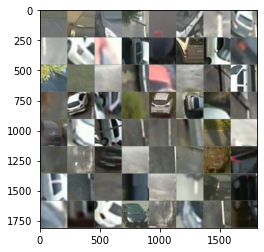

In [10]:
train_loader = DataLoader(trainDataset, batch_size=64, shuffle=True, drop_last=False)
imshow(train_loader)

In [11]:
net = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [12]:
RETRAIN = True

In [13]:
if RETRAIN:
    loss = train(18, trainDataset, net, criterion, device)
    PATH = 'models/AlexNettrainDistribution.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(loss)
    with open("losses/trainLossAlexNetTrainDistribution.txt", "w") as file:
        file.write(str(loss))   
else:
    PATH = 'models/AlexNettrainDistribution.pth'
    net.load_state_dict(torch.load(PATH))

Number of batches to train:  560
Epoch 1.
Epoch 1.	Batch 2.	Loss = 0.693.
Epoch 1.	Batch 3.	Loss = 1.386.
Epoch 1.	Batch 4.	Loss = 2.079.
Epoch 1.	Batch 5.	Loss = 2.772.
Epoch 1.	Batch 6.	Loss = 3.466.
Epoch 1.	Batch 7.	Loss = 4.159.
Epoch 1.	Batch 8.	Loss = 4.852.
Epoch 1.	Batch 9.	Loss = 5.545.
Epoch 1.	Batch 10.	Loss = 6.239.
Epoch 1.	Batch 11.	Loss = 6.932.
Epoch 1.	Batch 12.	Loss = 7.624.
Epoch 1.	Batch 13.	Loss = 8.315.
Epoch 1.	Batch 14.	Loss = 9.009.
Epoch 1.	Batch 15.	Loss = 9.701.
Epoch 1.	Batch 16.	Loss = 10.392.
Epoch 1.	Batch 17.	Loss = 11.085.
Epoch 1.	Batch 18.	Loss = 11.777.
Epoch 1.	Batch 19.	Loss = 12.467.
Epoch 1.	Batch 20.	Loss = 13.162.
Epoch 1.	Batch 21.	Loss = 13.857.
Epoch 1.	Batch 22.	Loss = 14.548.
Epoch 1.	Batch 23.	Loss = 15.239.
Epoch 1.	Batch 24.	Loss = 15.932.
Epoch 1.	Batch 25.	Loss = 16.621.
Epoch 1.	Batch 26.	Loss = 17.314.
Epoch 1.	Batch 27.	Loss = 18.009.
Epoch 1.	Batch 28.	Loss = 18.700.
Epoch 1.	Batch 29.	Loss = 19.390.
Epoch 1.	Batch 30.	Loss = 20

In [14]:
results = pd.DataFrame()

In [53]:
for i, key in enumerate(pathsTeste):
    accuracy, auc = test(testDatasets[i], net, device)
    print("\nThe accuracy of testing on '{}' is {:.3f}.".format(key, accuracy))
    results = pd.concat([results, pd.DataFrame({
                                            "Dataset": [key],
                                            "Accuracy": [accuracy],
                                            "Auc": [auc],
                                            "Sample": [0.1]})])


Testing starts now...
Number of batches to test:  7
Testing on batch 1
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([25, 3, 224, 224])

The accuracy of testing on 'camera2' is 0.866.

Testing starts now...
Number of batches to test:  26
Testing on batch 1
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
Testing on batch 11
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.S

In [17]:
results

,Dataset,Accuracy,Auc,Sample
0,camera2,0.882641,0.894159,0.1
0,camera4,0.900422,0.908138,0.1
0,camera6,0.912935,0.913619,0.1
0,camera8,0.901912,0.903673,0.1
0,PUC,0.935838,0.938830,0.1
0,B,0.781591,0.789445,0.1


In [18]:
results.to_csv("results/trainDistributionResults.csv")

### Custom Image Inference

In [54]:
preds = []
names = []
correct = 0
total = 0
item = 1
with torch.no_grad():
  for root, dirs, files in os.walk("PKLot/PKLot/PKLotSegmented/PUC/Rainy/2012-09-21"):
    for fil in files:
      if '2012-09-21_07_30_14' in fil:
        names.append(fil)
        img = transform(Image.open(root + '/' + fil)).to(device)[None, :]
        outputs = net(img)
        _, predicted = torch.max(outputs.data, 1)
        preds.append(int(predicted))
        if 'Empty' in root:
          label = torch.Tensor([0]).to(device)
        else:
          label = torch.Tensor([1]).to(device)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        item += 1


In [55]:
accuracy = correct/total
print("\nThe accuracy of is {:.3f}.".format(accuracy))


The accuracy of is 0.910.


In [56]:
with open('PKLot/PKLot/PKLot/PUCPR/Rainy/2012-09-21/2012-09-21_07_30_14.xml') as f:
  content=f.read()
  d = xmltodict.parse(content)
  coord = []
  for fil in names:
    coo = d['parking']['space'][int(fil[-7:-4])-1]['contour']['point']
    coord.append([[int(x['@x']), int(x['@y'])] for x in coo])

In [58]:
img = cv2.imread("PKLot/PKLot/PKLot/PUCPR/Rainy/2012-09-21/2012-09-21_07_30_14.jpg")

for i, co in enumerate(coord):
  pts = np.array(co, np.int32)
  pts = pts.reshape((-1,1,2))
  if preds[i] == 0:
    c = (0,255,255)
  else:
    c = (255, 0, 0)
  cv2.polylines(img,[pts],True,c, 2)

while(1):
     
    cv2.imshow('image', img)
    if cv2.waitKey(20) & 0xFF == 27:
        break
cv2.destroyAllWindows()